<a href="https://colab.research.google.com/github/aneesahmedlarik/AI-notepad-in-java/blob/main/RemoteSensing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install split-folders for easy data splitting
!pip install split-folders --quiet

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
## 1. Setup and Imports

import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
import splitfolders
import cv2
from glob import glob
from tqdm.notebook import tqdm

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


# Define model parameters
IMG_SIZE = 256
NUM_CLASSES = 6
BATCH_SIZE = 8  # Adjust based on your GPU VRAM
EPOCHS = 50


# ... (Keep your other imports here: keras, sklearn, etc.) ...

# --- UPDATED PATHS BASED ON YOUR SCREENSHOT ---
# Path structure: My Drive -> Colab Notebooks -> patches
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/patches'

# Define dataset paths
IMAGE_DIR = os.path.join(BASE_PATH, 'Images')
LABEL_DIR = os.path.join(BASE_PATH, 'Labels')

# --- VERIFICATION STEP ---
print(f"Checking for images in: {IMAGE_DIR}")

if os.path.exists(IMAGE_DIR):
    # Check for TIF files
    files = glob(os.path.join(IMAGE_DIR, '*.tif'))
    print(f"Found {len(files)} images.")

    if len(files) > 0:
        print("Success! First file:", files[0])
    else:
        print("Directory found, but it is empty. Please check if images are .tif, .png, or .jpg")
else:
    print(f"ERROR: Directory still not found at {IMAGE_DIR}")
    print("Please verify: Is 'Colab Notebooks' spelled exactly this way in your Drive?")

Checking for images in: /content/drive/MyDrive/Colab Notebooks/patches/Images
Found 2400 images.
Success! First file: /content/drive/MyDrive/Colab Notebooks/patches/Images/Image_2231.tif


In [4]:
## 2. Data Preparation and Splitting

def get_class_map():
    """Defines the color-to-class mapping for the ISPRS Potsdam/Vaihingen dataset masks."""
    return {
        (255, 255, 255): 0,  # Impervious surfaces -> White
        (0, 0, 255): 1,      # Building -> Blue
        (0, 255, 255): 2,    # Low vegetation -> Cyan
        (0, 255, 0): 3,      # Tree -> Green
        (255, 255, 0): 4,    # Car -> Yellow
        (255, 0, 0): 5       # Clutter/Background -> Red
    }

def mask_to_class(mask, class_map):
    """Converts an RGB mask (256x256x3) to a categorical mask (256x256x1) based on the class map."""
    target_mask = np.zeros(mask.shape[:2], dtype=np.uint8)
    for rgb, class_id in class_map.items():
        # Match pixel where all three R, G, B channels are equal to the target color
        indices = np.all(mask == np.array(rgb), axis=-1)
        target_mask[indices] = class_id
    return target_mask

def load_data(image_dir, label_dir, img_size):
    """Loads all image and label patches from the directories."""
    image_paths = sorted(glob(os.path.join(image_dir, '*.tif')))
    label_paths = sorted(glob(os.path.join(label_dir, '*.tif')))

    X = []
    y = []
    class_map = get_class_map()

    print(f"Loading {len(image_paths)} image-mask pairs...")
    for img_path, label_path in tqdm(zip(image_paths, label_paths), total=len(image_paths)):
        # Load image (ensure 3 channels for satellite data: R, G, B or R, G, IR)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        # OpenCV reads as BGR, but we use it consistently
        img = cv2.resize(img, (img_size, img_size))

        # Load mask (labels are RGB)
        mask = cv2.imread(label_path, cv2.IMREAD_COLOR)
        mask = cv2.resize(mask, (img_size, img_size), interpolation=cv2.INTER_NEAREST)

        # Convert RGB mask to single-channel class mask
        class_mask = mask_to_class(mask, class_map)

        X.append(img)
        y.append(class_mask)

    return np.array(X), np.array(y)

# Load data
X, y = load_data(IMAGE_DIR, LABEL_DIR, IMG_SIZE)

# Normalize Images
X = X / 255.0

# Split data (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

print(f"\nTraining Images: {len(X_train)}")
print(f"Validation Images: {len(X_val)}")

Loading 2400 image-mask pairs...


  0%|          | 0/2400 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [5]:
from tensorflow.keras.metrics import MeanIoU

# We need the NUM_CLASSES global variable here
global NUM_CLASSES

class SparseMeanIoU(MeanIoU):
    """
    MeanIoU wrapper to handle Sparse (integer) labels when calculating IoU.
    This bypasses the Toutput_types error by using a built-in metric class.
    """
    def __init__(self, num_classes=NUM_CLASSES, name=None, dtype=None):
        super(SparseMeanIoU, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        self.num_classes = num_classes

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Cast y_true to the required integer format
        y_true = K.cast(y_true, 'int32')
        # Squeeze the last dimension (1) from y_true
        y_true = K.squeeze(y_true, axis=-1)
        # Convert prediction probabilities to hard class indices
        y_pred = K.argmax(y_pred, axis=-1)

        return super(SparseMeanIoU, self).update_state(y_true, y_pred, sample_weight)

class SparseDiceCoefficient(tf.keras.metrics.Metric):
    """Custom Dice Coefficient that correctly handles Sparse (integer) labels."""
    def __init__(self, name='sparse_dice_coef', **kwargs):
        super(SparseDiceCoefficient, self).__init__(name=name, **kwargs)
        self.dice_sum = self.add_weight(name='dice_sum', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # 1. Convert y_true (integer mask) to one-hot encoding
        y_true_one_hot = K.one_hot(K.cast(y_true, dtype='int32'), num_classes=NUM_CLASSES)
        y_true_one_hot = K.squeeze(y_true_one_hot, axis=-2)

        y_true_f = K.flatten(y_true_one_hot)
        y_pred_f = K.flatten(y_pred)

        smooth = 1e-6
        intersection = K.sum(y_true_f * y_pred_f)
        union = K.sum(y_true_f) + K.sum(y_pred_f)
        dice = (2. * intersection + smooth) / (union + smooth)

        self.dice_sum.assign_add(dice)
        self.count.assign_add(1.0)

    def result(self):
        return self.dice_sum / self.count

    def reset_state(self):
        self.dice_sum.assign(0.0)
        self.count.assign(0.0)

# Initialize the new metric classes
sparse_iou = SparseMeanIoU(num_classes=NUM_CLASSES, name='sparse_iou')
sparse_dice = SparseDiceCoefficient(name='sparse_dice')

In [6]:
## 4. U-Net Model Definition

def conv_block(input_tensor, num_filters):
    """Standard convolutional block: Conv -> ReLU -> Conv -> ReLU"""
    x = Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    return x

def build_unet(input_shape, num_classes):
    """Builds the U-Net model."""
    inputs = Input(input_shape)

    # 1. ENCODER (Contracting Path)
    c1 = conv_block(inputs, 16)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 32)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 64)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 128)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = conv_block(p4, 256)

    # 2. DECODER (Expansive Path)
    # Block 1
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = conv_block(u6, 128)

    # Block 2
    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = conv_block(u7, 64)

    # Block 3
    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = conv_block(u8, 32)

    # Block 4
    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = conv_block(u9, 16)

    # Output Layer
    # Use 'softmax' for multi-class prediction
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = keras.Model(inputs=[inputs], outputs=[outputs])
    return model

# Instantiate and compile the model
model = build_unet((IMG_SIZE, IMG_SIZE, 3), NUM_CLASSES)

# Use the instantiated metric objects
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', sparse_iou, sparse_dice])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation_4[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ activation_5[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[

 Total params: 1,962,710 (7.49 MB)

 Trainable params: 1,962,710 (7.49 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
import os
import shutil
import gc
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import mixed_precision
from google.colab import drive

# 1. Enable Mixed Precision (Speeds up training & saves VRAM)
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print(f"✅ Mixed Precision Enabled: {policy.name}")

# 2. Mount Drive
drive.mount('/content/drive')

✅ Mixed Precision Enabled: mixed_float16
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Define your Source (Drive) and Destination (Local Colab)
SOURCE_PATH = '/content/drive/MyDrive/Colab Notebooks/patches'
LOCAL_PATH = '/content/patches'

print("⏳ Copying data from Drive to Local Disk... (Please wait, this speeds up training 10x)")

if not os.path.exists(LOCAL_PATH):
    try:
        shutil.copytree(SOURCE_PATH, LOCAL_PATH)
        print(f"✅ Success! Data copied to {LOCAL_PATH}")
    except Exception as e:
        print(f"❌ Error copying data: {e}")
        print("Check if your Drive path is exactly correct.")
else:
    print("✅ Data already exists locally. Skipping copy.")

# UPDATE PATHS TO USE LOCAL DATA
IMAGE_DIR = os.path.join(LOCAL_PATH, 'Images')
LABEL_DIR = os.path.join(LOCAL_PATH, 'Labels')

⏳ Copying data from Drive to Local Disk... (Please wait, this speeds up training 10x)
✅ Success! Data copied to /content/patches


In [10]:
import numpy as np
import gc

# 1. Load Data
# (We are NOT normalizing yet to save memory)
print("Loading raw data...")
X, y = load_data(IMAGE_DIR, LABEL_DIR, 256)

print(f"Loaded {len(X)} images.")

Loading raw data...
Loading 2400 image-mask pairs...


  0%|          | 0/2400 [00:00<?, ?it/s]

Loaded 2400 images.


In [11]:
from sklearn.model_selection import train_test_split

print("Splitting data...")
# Split the raw uint8 data (much smaller in RAM than float32)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# IMMEDIATELY delete the original big lists to free RAM
del X
del y
gc.collect()

print("Original big arrays deleted. RAM should be safer now.")

Splitting data...
Original big arrays deleted. RAM should be safer now.


In [12]:
import numpy as np
import gc

print("Processing Training Images...")

# Ensure X_train exists from the split step
if 'X_train' not in locals():
    raise ValueError("ERROR: X_train is missing. Please run the 'Split Data' cell first.")

# Convert to float32 and normalize
# We rename it to X_train_f to match your training code
X_train_f = X_train.astype(np.float32) / 255.0

# Delete the old variable to free memory
del X_train
gc.collect()

print("✅ X_train_f created.")

Processing Training Images...
✅ X_train_f created.


In [13]:
print("Processing Validation Images...")

if 'X_val' not in locals():
    raise ValueError("ERROR: X_val is missing. Please run the 'Split Data' cell first.")

# Convert to float32 and normalize
X_val_f = X_val.astype(np.float32) / 255.0

del X_val
gc.collect()

print("✅ X_val_f created.")

Processing Validation Images...
✅ X_val_f created.


In [14]:
print("Processing Masks...")

if 'y_train' not in locals() or 'y_val' not in locals():
    raise ValueError("ERROR: y_train or y_val is missing.")

# Expand dims and cast to int32 for Training
y_train_r = np.expand_dims(y_train, axis=-1).astype(np.int32)
del y_train

# Expand dims and cast to int32 for Validation
y_val_r = np.expand_dims(y_val, axis=-1).astype(np.int32)
del y_val

gc.collect()

print("✅ y_train_r and y_val_r created.")

Processing Masks...
✅ y_train_r and y_val_r created.


In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.models import load_model

# --- PATHS FOR SAVING (Keep these on Drive so they are safe) ---
DRIVE_OUTPUT_DIR = '/content/drive/MyDrive/Colab Notebooks/patches/training_logs'
MODEL_PATH = os.path.join(DRIVE_OUTPUT_DIR, 'best_unet_segmentation.keras')
CSV_PATH = os.path.join(DRIVE_OUTPUT_DIR, 'training_log.csv')

if not os.path.exists(DRIVE_OUTPUT_DIR):
    os.makedirs(DRIVE_OUTPUT_DIR)

# --- CHECK FOR RESUME ---
initial_epoch = 0
if os.path.exists(MODEL_PATH):
    print(f"🔄 Found saved model. Attempting to resume...")
    try:
        # NOTE: Pass your custom metric function here if needed, e.g., {'sparse_iou': sparse_iou}
        model = load_model(MODEL_PATH, compile=False)

        # Recompile is needed after loading to ensure metrics are active
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) # Add your custom metric back here if needed

        # Check logs for epoch number
        if os.path.exists(CSV_PATH):
            import pandas as pd
            log_data = pd.read_csv(CSV_PATH)
            initial_epoch = log_data['epoch'].max() + 1
            print(f"✅ Resuming from Epoch {initial_epoch}")
    except Exception as e:
        print(f"⚠️ Could not load model ({e}). Starting fresh.")
else:
    print("🆕 Starting training from scratch.")

# --- CALLBACKS ---
callbacks = [
    CSVLogger(CSV_PATH, separator=',', append=True),
    ModelCheckpoint(MODEL_PATH, monitor='val_loss', mode='min', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]

# --- TRAIN ---
print(f"🚀 Starting Training (Epochs {initial_epoch} - 50)...")
history = model.fit(
    X_train_f, y_train_r,
    batch_size=8, # Try 8 or 16. If RAM crashes, lower to 4.
    epochs=50,
    initial_epoch=initial_epoch,
    validation_data=(X_val_f, y_val_r),
    callbacks=callbacks,
    verbose=1,
    shuffle=True
)

🆕 Starting training from scratch.
🚀 Starting Training (Epochs 0 - 50)...
Epoch 1/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.2769 - loss: 1.6511 - sparse_dice: 0.2087 - sparse_iou: 0.0794
Epoch 1: val_loss improved from inf to 1.35153, saving model to /content/drive/MyDrive/Colab Notebooks/patches/training_logs/best_unet_segmentation.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 49s 105ms/step - accuracy: 0.2770 - loss: 1.6507 - sparse_dice: 0.2088 - sparse_iou: 0.0794 - val_accuracy: 0.4953 - val_loss: 1.3515 - val_sparse_dice: 0.2937 - val_sparse_iou: 0.1653 - learning_rate: 1.0000e-04
Epoch 2/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4631 - loss: 1.3031 - sparse_dice: 0.3298 - sparse_iou: 0.1626
Epoch 2: val_loss improved from 1.35153 to 1.23427, saving model to /content/drive/MyDrive/Colab Notebooks/patches/training_logs/best_unet_segmentation.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.4631 - loss: 1.3030 - sparse_dice: 0.3298 - sparse_iou: 

✅ Found log file. Generating plots...


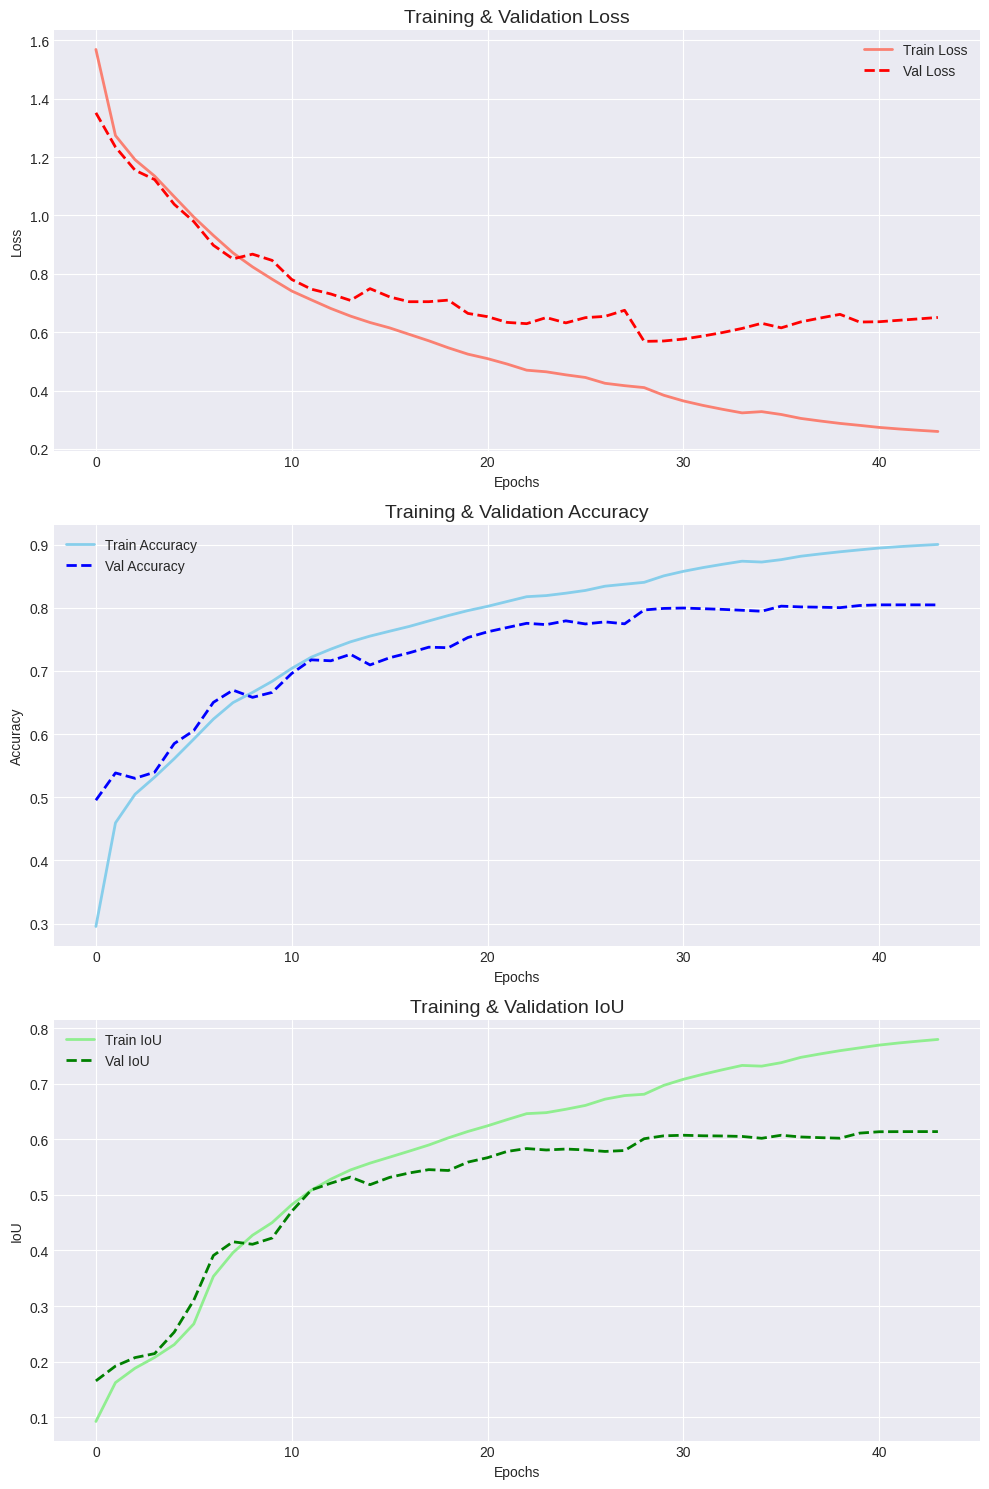

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- PATH TO YOUR LOG FILE ---
# This matches the path we defined in the previous steps
LOG_FILE = '/content/drive/MyDrive/Colab Notebooks/patches/training_logs/training_log.csv'

# Check if file exists
if not os.path.exists(LOG_FILE):
    print(f"❌ Could not find log file at: {LOG_FILE}")
    print("If you just started training, wait for Epoch 1 to finish.")
else:
    print(f"✅ Found log file. Generating plots...")

    # Load the data
    history_df = pd.read_csv(LOG_FILE)

    # Set the style
    plt.style.use('seaborn-v0_8-darkgrid')

    # Create a figure with 2 (or 3) subplots
    # We check if 'val_sparse_iou' or 'val_iou' exists to decide if we plot IoU
    has_iou = any(col for col in history_df.columns if 'iou' in col.lower())
    rows = 3 if has_iou else 2

    fig, axes = plt.subplots(rows, 1, figsize=(10, 5 * rows))

    # --- PLOT 1: LOSS ---
    axes[0].plot(history_df['epoch'], history_df['loss'], label='Train Loss', color='salmon', linewidth=2)
    axes[0].plot(history_df['epoch'], history_df['val_loss'], label='Val Loss', color='red', linestyle='--', linewidth=2)
    axes[0].set_title('Training & Validation Loss', fontsize=14)
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # --- PLOT 2: ACCURACY ---
    # Check column names (sometimes it's 'acc', sometimes 'accuracy')
    acc_col = 'accuracy' if 'accuracy' in history_df.columns else 'acc'
    val_acc_col = 'val_accuracy' if 'val_accuracy' in history_df.columns else 'val_acc'

    if acc_col in history_df.columns:
        axes[1].plot(history_df['epoch'], history_df[acc_col], label='Train Accuracy', color='skyblue', linewidth=2)
        axes[1].plot(history_df['epoch'], history_df[val_acc_col], label='Val Accuracy', color='blue', linestyle='--', linewidth=2)
        axes[1].set_title('Training & Validation Accuracy', fontsize=14)
        axes[1].set_xlabel('Epochs')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend()
        axes[1].grid(True)

    # --- PLOT 3: IoU (If available) ---
    if has_iou:
        # Find the specific column names for IoU
        iou_cols = [c for c in history_df.columns if 'iou' in c.lower() and 'val' not in c.lower()]
        val_iou_cols = [c for c in history_df.columns if 'iou' in c.lower() and 'val' in c.lower()]

        if iou_cols:
            axes[2].plot(history_df['epoch'], history_df[iou_cols[0]], label='Train IoU', color='lightgreen', linewidth=2)
        if val_iou_cols:
            axes[2].plot(history_df['epoch'], history_df[val_iou_cols[0]], label='Val IoU', color='green', linestyle='--', linewidth=2)

        axes[2].set_title('Training & Validation IoU', fontsize=14)
        axes[2].set_xlabel('Epochs')
        axes[2].set_ylabel('IoU')
        axes[2].legend()
        axes[2].grid(True)

    plt.tight_layout()
    plt.show()

Processing sample 1/12 (Index: 452)...
Processing sample 2/12 (Index: 84)...
Processing sample 3/12 (Index: 434)...
Processing sample 4/12 (Index: 474)...
Processing sample 5/12 (Index: 428)...
Processing sample 6/12 (Index: 312)...
Processing sample 7/12 (Index: 30)...
Processing sample 8/12 (Index: 220)...
Processing sample 9/12 (Index: 188)...
Processing sample 10/12 (Index: 231)...
Processing sample 11/12 (Index: 9)...
Processing sample 12/12 (Index: 124)...


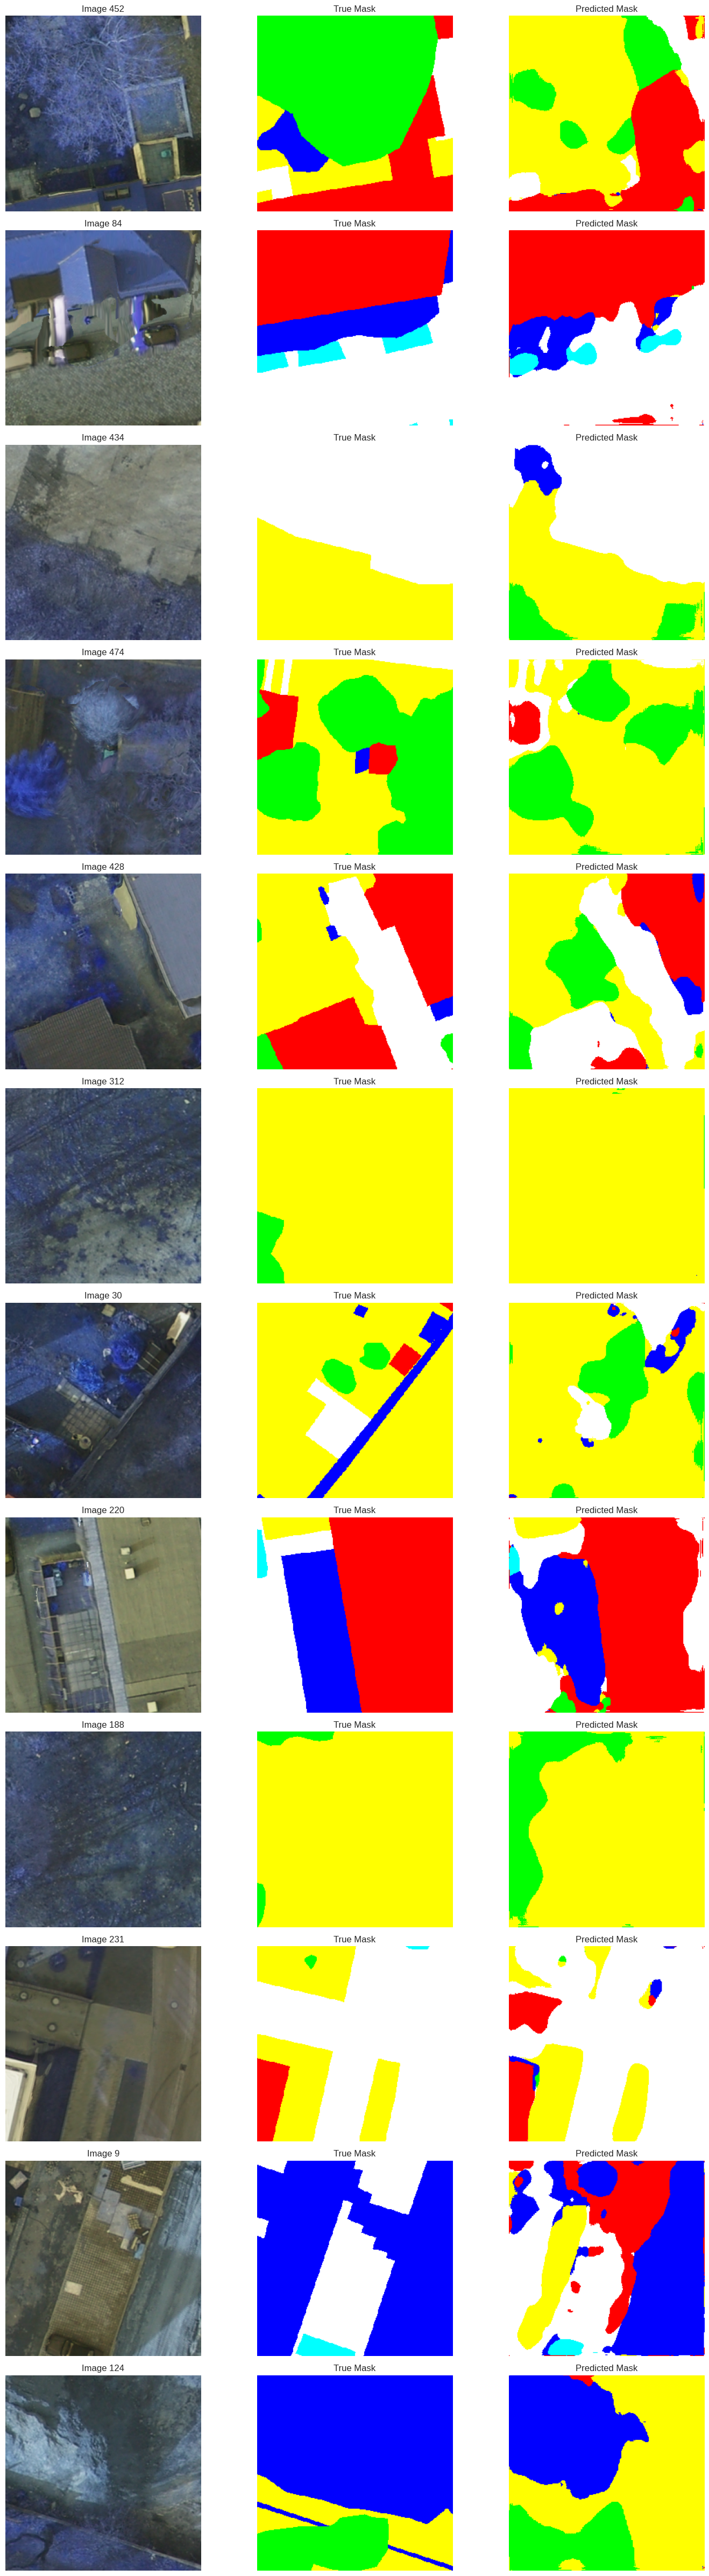

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. DEFINE COLOR MAP (Same as before) ---
id_to_color = {
    0: (255, 255, 255), # Impervious surfaces (White)
    1: (0, 0, 255),     # Building (Blue)
    2: (0, 255, 255),   # Low vegetation (Cyan)
    3: (0, 255, 0),     # Tree (Green)
    4: (255, 255, 0),   # Car (Yellow)
    5: (255, 0, 0)      # Clutter (Red)
}

def decode_mask(mask_id):
    """Converts a mask of class IDs (H, W) into an RGB image (H, W, 3)."""
    h, w = mask_id.shape
    mask_rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for class_id, color in id_to_color.items():
        mask_rgb[mask_id == class_id] = color
    return mask_rgb

# --- 2. GENERATE MULTIPLE PREDICTIONS ---
def show_multiple_predictions(model, X_val, y_val, num_samples=12):
    """
    Picks 'num_samples' random images and plots them in a grid.
    """
    # Pick random indices
    indices = np.random.choice(len(X_val), num_samples, replace=False)

    # Create a figure with num_samples rows and 3 columns
    # Adjust height based on number of samples (4 inches per row)
    plt.figure(figsize=(15, 4 * num_samples))

    for i, index in enumerate(indices):
        print(f"Processing sample {i+1}/{num_samples} (Index: {index})...")

        # Get Data
        original_img = X_val[index]
        true_mask_id = y_val[index].squeeze()

        # Predict
        input_img = np.expand_dims(original_img, axis=0)
        prediction_raw = model.predict(input_img, verbose=0)
        predicted_mask_id = np.argmax(prediction_raw, axis=-1).squeeze()

        # Decode to RGB
        true_mask_rgb = decode_mask(true_mask_id)
        predicted_mask_rgb = decode_mask(predicted_mask_id)

        # --- PLOT (Row i) ---

        # 1. Original Image
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(original_img)
        plt.title(f"Image {index}")
        plt.axis('off')

        # 2. True Mask
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(true_mask_rgb)
        plt.title("True Mask")
        plt.axis('off')

        # 3. Predicted Mask
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(predicted_mask_rgb)
        plt.title("Predicted Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# --- RUN IT ---
# This will generate a long vertical image with 12 examples
show_multiple_predictions(model, X_val_f, y_val_r, num_samples=12)

Generating Confusion Matrix using 100 random samples...
Predicting...
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 837ms/step
Calculating Confusion Matrix...


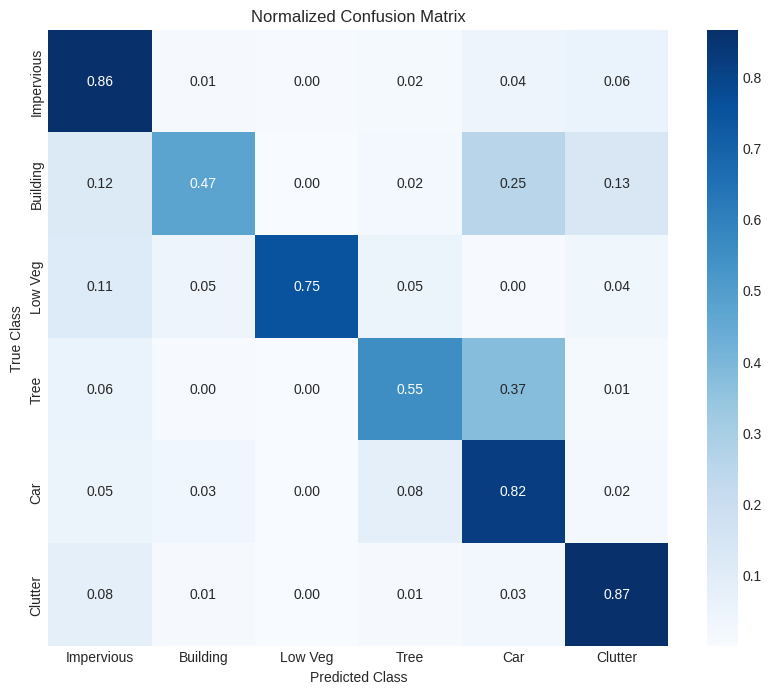

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define Class Names for the Matrix
class_names = ['Impervious', 'Building', 'Low Veg', 'Tree', 'Car', 'Clutter']

def plot_confusion_matrix(model, X_val, y_val, num_samples=50):
    """
    Computes and plots the confusion matrix based on a subset of validation data.
    """
    print(f"Generating Confusion Matrix using {num_samples} random samples...")

    # 1. Pick random samples to avoid RAM crash (analyzing all pixels takes huge RAM)
    indices = np.random.choice(len(X_val), num_samples, replace=False)
    X_subset = X_val[indices]
    y_subset = y_val[indices]

    # 2. Predict
    print("Predicting...")
    y_pred_probs = model.predict(X_subset, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=-1) # Convert probs to Class IDs

    # 3. Flatten arrays (Matrix needs 1D list of all pixels)
    # y_subset is (N, 256, 256, 1) -> flatten to 1D
    true_pixels = y_subset.flatten()
    # y_pred is (N, 256, 256) -> flatten to 1D
    pred_pixels = y_pred.flatten()

    # 4. Compute Matrix
    print("Calculating Confusion Matrix...")
    cm = confusion_matrix(true_pixels, pred_pixels, labels=range(6))

    # 5. Normalize (so we see percentages, not just raw counts)
    # We divide each row by the sum of that row (True Class Total)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # 6. Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)

    plt.title('Normalized Confusion Matrix')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.show()

# --- RUN IT ---
# Using 50-100 samples gives a very good estimate without crashing RAM
plot_confusion_matrix(model, X_val_f, y_val_r, num_samples=100)

Computing metrics...


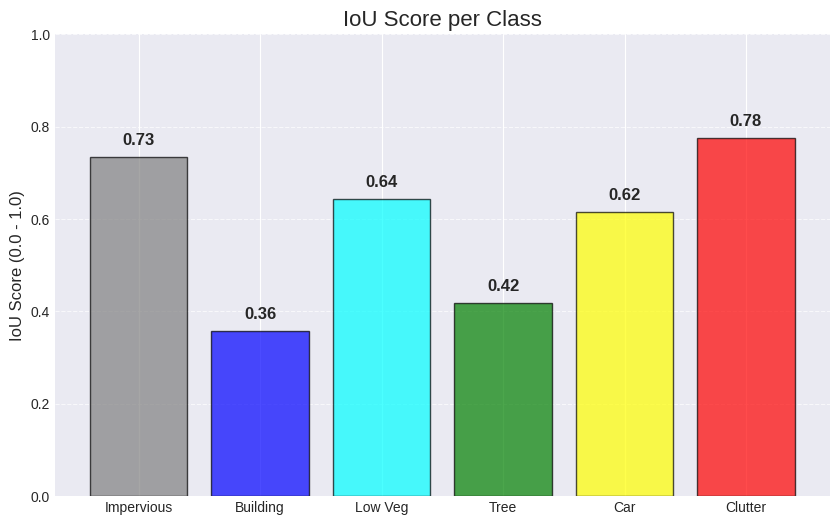

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Use the same class names and confusion matrix from the previous step
class_names = ['Impervious', 'Building', 'Low Veg', 'Tree', 'Car', 'Clutter']

def plot_per_class_iou(model, X_val, y_val, num_samples=100):
    # 1. Re-calculate Confusion Matrix (if you didn't save 'cm' from previous step)
    # Note: If you have 'cm' from the previous cell, you can skip this block
    print("Computing metrics...")
    indices = np.random.choice(len(X_val), num_samples, replace=False)
    y_pred = np.argmax(model.predict(X_val[indices], verbose=0), axis=-1).flatten()
    y_true = y_val[indices].flatten()

    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(6))

    # 2. Calculate IoU per class
    # IoU = TP / (TP + FP + FN)
    intersection = np.diag(cm)
    ground_truth_set = cm.sum(axis=1) # Rows = GT
    predicted_set = cm.sum(axis=0)    # Cols = Pred
    union = ground_truth_set + predicted_set - intersection

    # Avoid division by zero
    iou = intersection / np.maximum(union, 1)

    # 3. Plot
    plt.figure(figsize=(10, 6))
    colors = ['gray', 'blue', 'cyan', 'green', 'yellow', 'red'] # Match your class map
    bars = plt.bar(class_names, iou, color=colors, edgecolor='black', alpha=0.7)

    plt.title('IoU Score per Class', fontsize=16)
    plt.ylabel('IoU Score (0.0 - 1.0)', fontsize=12)
    plt.ylim(0, 1.0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add numbers on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{height:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.show()

plot_per_class_iou(model, X_val_f, y_val_r, num_samples=100)

Scoring all validation images (this might take a moment)...
Displaying 3 Worst and 3 Best predictions...


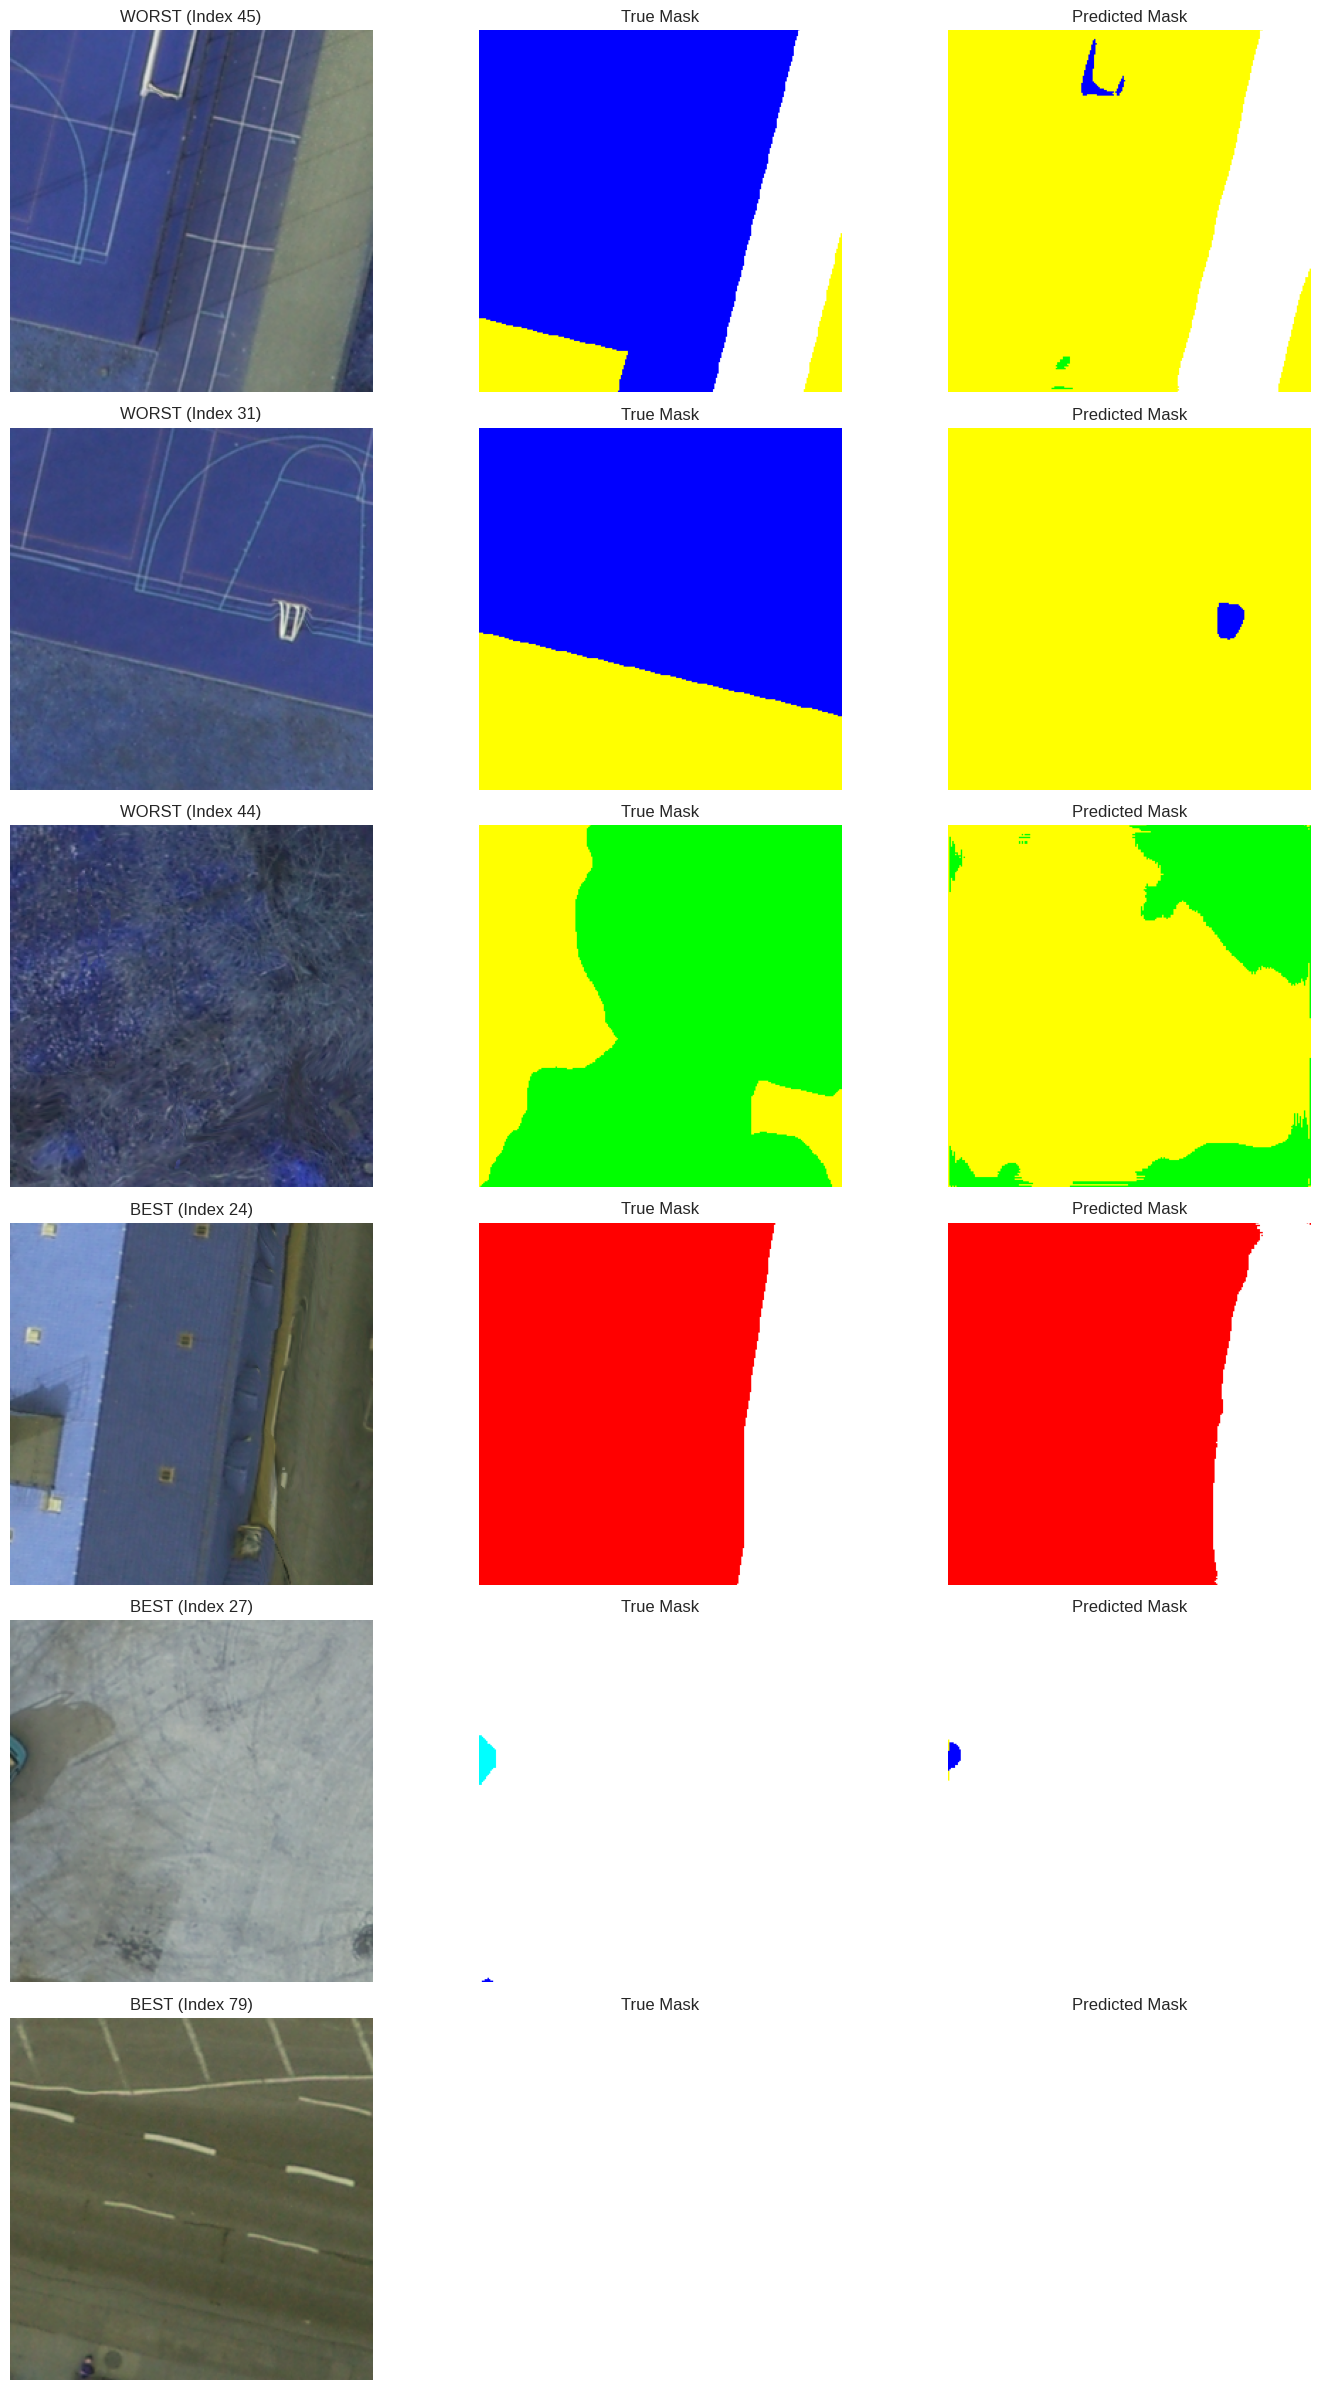

In [31]:
def plot_best_worst(model, X_val, y_val, n_best=3, n_worst=3):
    print("Scoring all validation images (this might take a moment)...")

    # Predict in batches to save RAM, but here we do simple loop for clarity
    ious = []

    # We will score the first 100 images to save time
    limit = min(100, len(X_val))

    for i in range(limit):
        # Quick IoU estimate using TF or simple numpy
        true = y_val[i].squeeze()
        # Shape needs to be (1, 256, 256, 3)
        pred_prob = model.predict(np.expand_dims(X_val[i], axis=0), verbose=0)
        pred = np.argmax(pred_prob, axis=-1).squeeze()

        # Simple accuracy as proxy for sorting (faster than full IoU calc)
        score = np.mean(true == pred)
        ious.append((score, i))

    # Sort: Low scores first
    ious.sort(key=lambda x: x[0])

    worst_indices = [x[1] for x in ious[:n_worst]]
    best_indices = [x[1] for x in ious[-n_best:]]

    print(f"Displaying {n_worst} Worst and {n_best} Best predictions...")

    # Reuse your existing show_multiple_predictions function logic
    # But pass specific indices

    # Combine lists
    target_indices = worst_indices + best_indices
    titles = ['WORST'] * n_worst + ['BEST'] * n_best

    plt.figure(figsize=(15, 4 * len(target_indices)))

    for i, index in enumerate(target_indices):
        original_img = X_val[index]
        true_mask_id = y_val[index].squeeze()

        input_img = np.expand_dims(original_img, axis=0)
        pred = np.argmax(model.predict(input_img, verbose=0), axis=-1).squeeze()

        # Plot
        plt.subplot(len(target_indices), 3, i*3 + 1)
        plt.imshow(original_img)
        plt.title(f"{titles[i]} (Index {index})")
        plt.axis('off')

        plt.subplot(len(target_indices), 3, i*3 + 2)
        plt.imshow(decode_mask(true_mask_id))
        plt.title("True Mask")
        plt.axis('off')

        plt.subplot(len(target_indices), 3, i*3 + 3)
        plt.imshow(decode_mask(pred))
        plt.title("Predicted Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_best_worst(model, X_val_f, y_val_r)

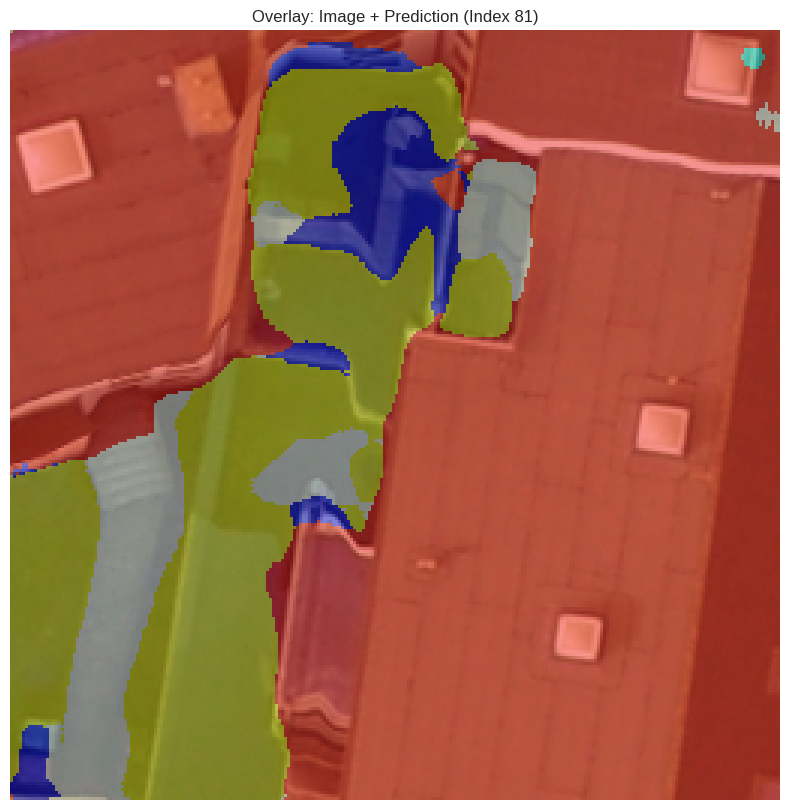

In [32]:
import cv2

def plot_overlay(model, X_val, y_val, index=None):
    if index is None: index = np.random.randint(0, len(X_val))

    img = X_val[index]
    # Predict
    pred = np.argmax(model.predict(np.expand_dims(img, axis=0), verbose=0), axis=-1).squeeze()
    mask_rgb = decode_mask(pred)

    # Blend: 60% Image, 40% Mask
    # Note: img is float (0-1), mask is int (0-255). We need to align them.
    img_uint8 = (img * 255).astype(np.uint8)

    overlay = cv2.addWeighted(img_uint8, 0.6, mask_rgb, 0.4, 0)

    plt.figure(figsize=(10, 10))
    plt.imshow(overlay)
    plt.title(f"Overlay: Image + Prediction (Index {index})")
    plt.axis('off')
    plt.show()

plot_overlay(model, X_val_f, y_val_r)

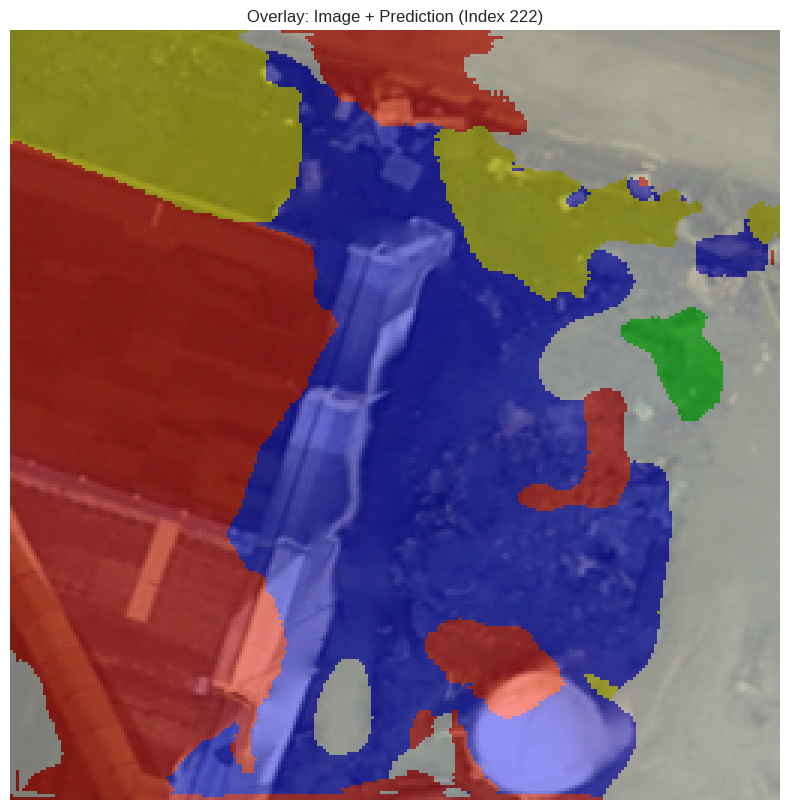

In [33]:
import cv2

def plot_overlay(model, X_val, y_val, index=None):
    if index is None: index = np.random.randint(0, len(X_val))

    img = X_val[index]
    # Predict
    pred = np.argmax(model.predict(np.expand_dims(img, axis=0), verbose=0), axis=-1).squeeze()
    mask_rgb = decode_mask(pred)

    # Blend: 60% Image, 40% Mask
    # Note: img is float (0-1), mask is int (0-255). We need to align them.
    img_uint8 = (img * 255).astype(np.uint8)

    overlay = cv2.addWeighted(img_uint8, 0.6, mask_rgb, 0.4, 0)

    plt.figure(figsize=(10, 10))
    plt.imshow(overlay)
    plt.title(f"Overlay: Image + Prediction (Index {index})")
    plt.axis('off')
    plt.show()

plot_overlay(model, X_val_f, y_val_r)

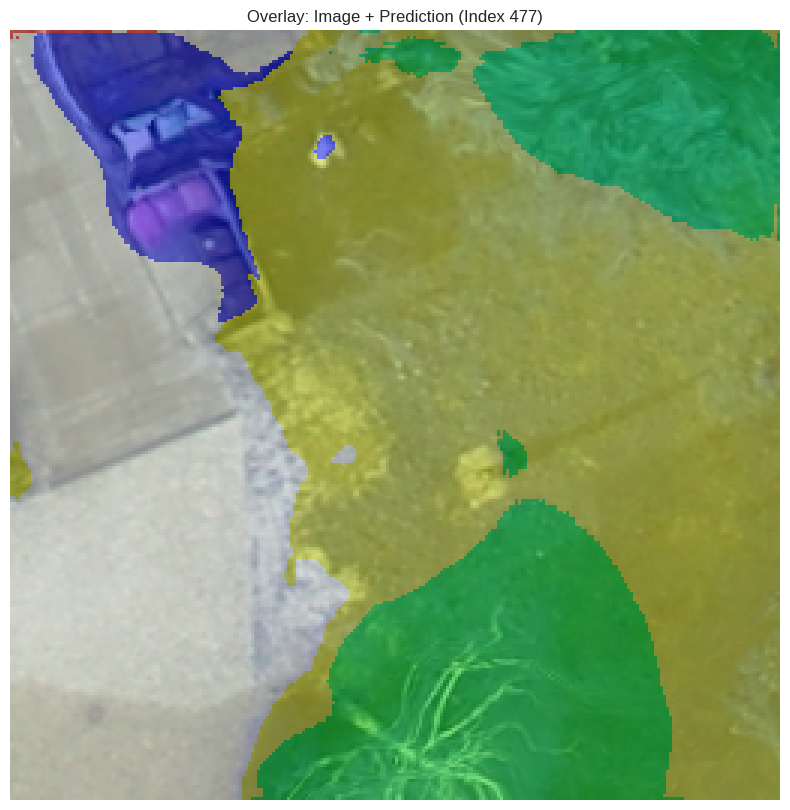

In [34]:
import cv2

def plot_overlay(model, X_val, y_val, index=None):
    if index is None: index = np.random.randint(0, len(X_val))

    img = X_val[index]
    # Predict
    pred = np.argmax(model.predict(np.expand_dims(img, axis=0), verbose=0), axis=-1).squeeze()
    mask_rgb = decode_mask(pred)

    # Blend: 60% Image, 40% Mask
    # Note: img is float (0-1), mask is int (0-255). We need to align them.
    img_uint8 = (img * 255).astype(np.uint8)

    overlay = cv2.addWeighted(img_uint8, 0.6, mask_rgb, 0.4, 0)

    plt.figure(figsize=(10, 10))
    plt.imshow(overlay)
    plt.title(f"Overlay: Image + Prediction (Index {index})")
    plt.axis('off')
    plt.show()

plot_overlay(model, X_val_f, y_val_r)

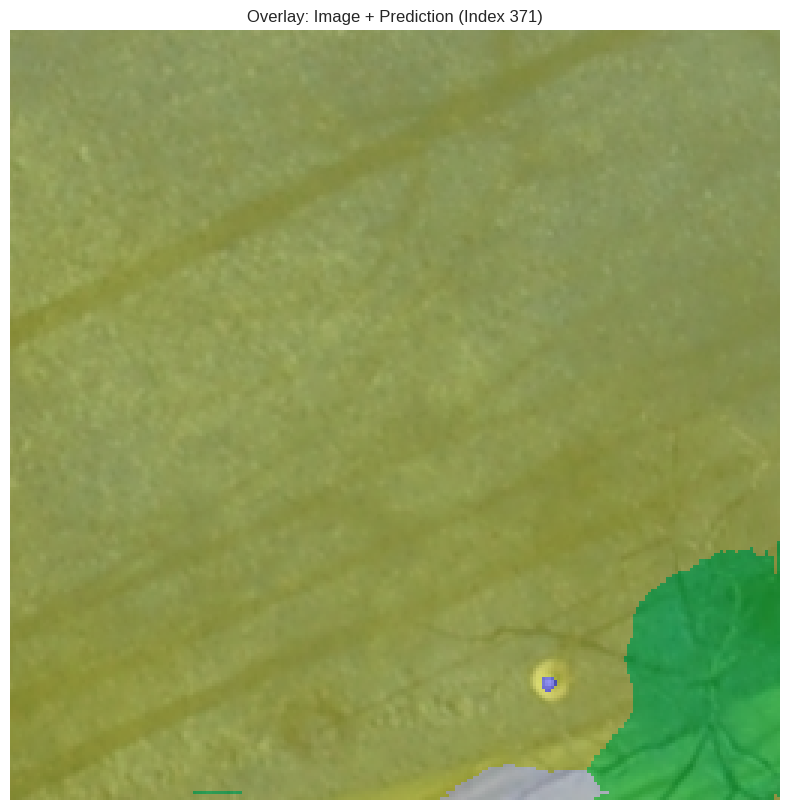

In [35]:
import cv2

def plot_overlay(model, X_val, y_val, index=None):
    if index is None: index = np.random.randint(0, len(X_val))

    img = X_val[index]
    # Predict
    pred = np.argmax(model.predict(np.expand_dims(img, axis=0), verbose=0), axis=-1).squeeze()
    mask_rgb = decode_mask(pred)

    # Blend: 60% Image, 40% Mask
    # Note: img is float (0-1), mask is int (0-255). We need to align them.
    img_uint8 = (img * 255).astype(np.uint8)

    overlay = cv2.addWeighted(img_uint8, 0.6, mask_rgb, 0.4, 0)

    plt.figure(figsize=(10, 10))
    plt.imshow(overlay)
    plt.title(f"Overlay: Image + Prediction (Index {index})")
    plt.axis('off')
    plt.show()

plot_overlay(model, X_val_f, y_val_r)

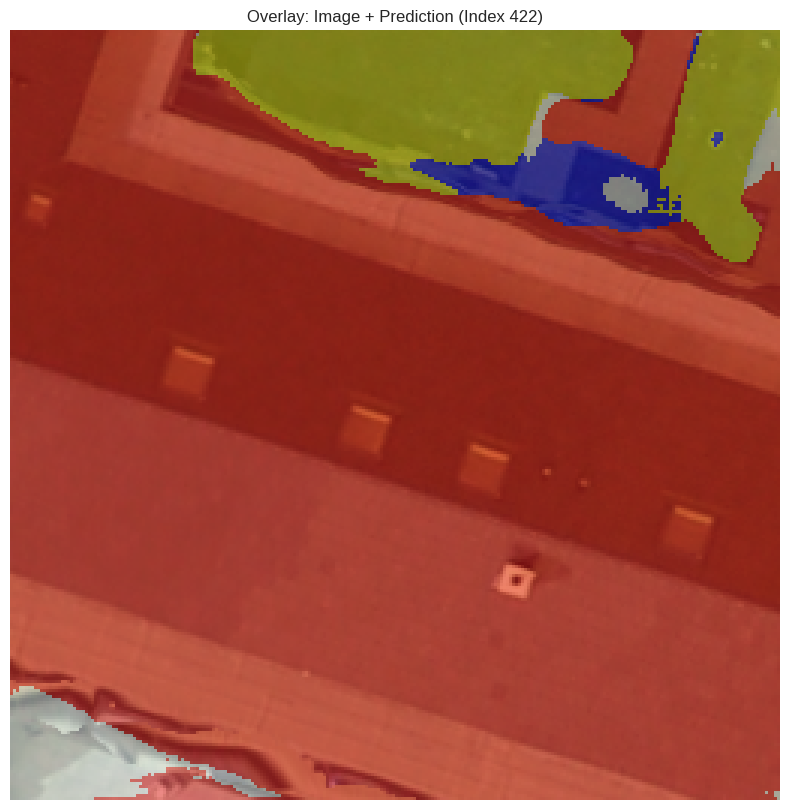

In [36]:
import cv2

def plot_overlay(model, X_val, y_val, index=None):
    if index is None: index = np.random.randint(0, len(X_val))

    img = X_val[index]
    # Predict
    pred = np.argmax(model.predict(np.expand_dims(img, axis=0), verbose=0), axis=-1).squeeze()
    mask_rgb = decode_mask(pred)

    # Blend: 60% Image, 40% Mask
    # Note: img is float (0-1), mask is int (0-255). We need to align them.
    img_uint8 = (img * 255).astype(np.uint8)

    overlay = cv2.addWeighted(img_uint8, 0.6, mask_rgb, 0.4, 0)

    plt.figure(figsize=(10, 10))
    plt.imshow(overlay)
    plt.title(f"Overlay: Image + Prediction (Index {index})")
    plt.axis('off')
    plt.show()

plot_overlay(model, X_val_f, y_val_r)

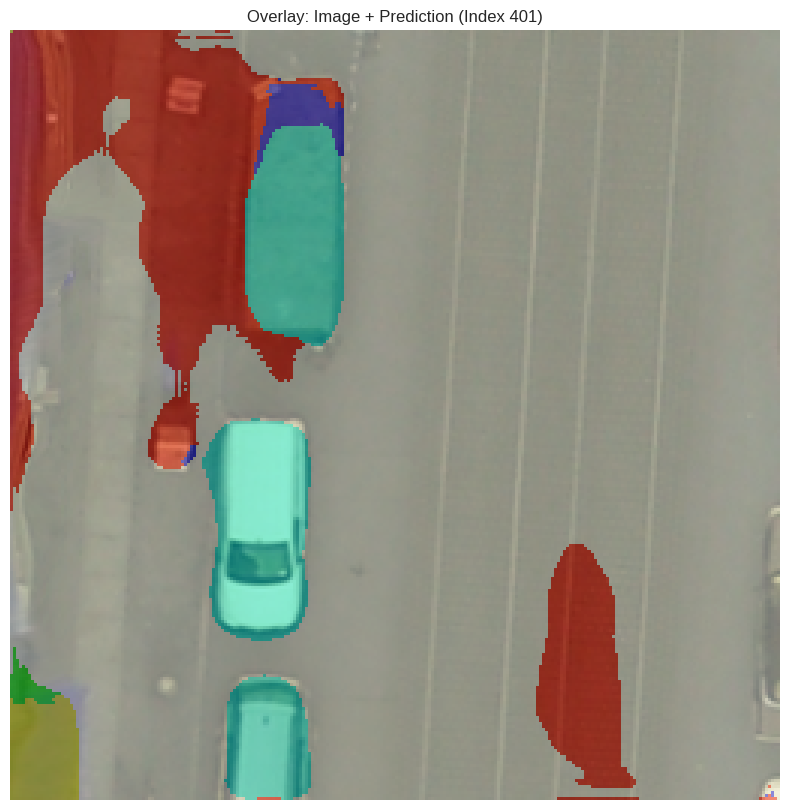

In [37]:
import cv2

def plot_overlay(model, X_val, y_val, index=None):
    if index is None: index = np.random.randint(0, len(X_val))

    img = X_val[index]
    # Predict
    pred = np.argmax(model.predict(np.expand_dims(img, axis=0), verbose=0), axis=-1).squeeze()
    mask_rgb = decode_mask(pred)

    # Blend: 60% Image, 40% Mask
    # Note: img is float (0-1), mask is int (0-255). We need to align them.
    img_uint8 = (img * 255).astype(np.uint8)

    overlay = cv2.addWeighted(img_uint8, 0.6, mask_rgb, 0.4, 0)

    plt.figure(figsize=(10, 10))
    plt.imshow(overlay)
    plt.title(f"Overlay: Image + Prediction (Index {index})")
    plt.axis('off')
    plt.show()

plot_overlay(model, X_val_f, y_val_r)